In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import spatial
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
data_path='./merfish_data'
import scipy as sp
import scipy.sparse.linalg
import h5py
import spatial.merfish_dataset
import torch_geometric
import torch
import pytorch_lightning as pl
import spatial.monet_ae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# get data

In [4]:
merfish_train=spatial.merfish_dataset.MerfishDataset(data_path,3,train=True)
merfish_test=spatial.merfish_dataset.MerfishDataset(data_path,3,train=False)

# train trivial model

In [5]:
model=spatial.monet_ae.TrivialAutoencoder(160,2,loss_type='mse_against_log1pdata').to('cuda')

In [6]:
logger=pl.loggers.TensorBoardLogger('./lightning_logs/',name='simpleae')

In [7]:
trainer = pl.Trainer(
    flush_logs_every_n_steps=12, log_every_n_steps=12, gpus=1, max_epochs=1,logger=logger
)
trainer.logger.name,trainer.logger.version

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


('simpleae', 3)

In [8]:

trainer.fit(
    model,
    torch_geometric.data.DataLoader(merfish_train, batch_size=10, num_workers=2,pin_memory=True),
    torch_geometric.data.DataLoader(merfish_test, batch_size=10, shuffle=False,pin_memory=True),
)


  | Name            | Type       | Params
-----------------------------------------------
0 | encoder_network | Sequential | 9.5 K 
1 | decoder_network | Sequential | 10.0 K
-----------------------------------------------
19.5 K    Trainable params
0         Non-trainable params
19.5 K    Total params
0.078     Total estimated model params size (MB)
/home/ubuntu/.cache/pypoetry/virtualenvs/spatial-0SaMOyjM-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/ubuntu/.cache/pypoetry/virtualenvs/spatial-0SaMOyjM-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

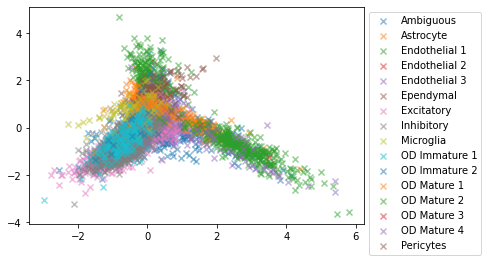

In [9]:
batch=merfish_test.get(0).to('cuda')
model=model.to('cuda')
reps,recon=model(batch)
reps=reps.detach().cpu().numpy()
types=batch.y.detach().cpu().numpy()[:,1]
for i,nm in enumerate(merfish_test.cell_types):
    good=types==i
    plt.scatter(reps[good,0],reps[good,1],alpha=.5,marker='x',label=nm)
plt.legend(bbox_to_anchor=[1,1])

# try graph version

In [8]:
model=spatial.monet_ae.MonetAutoencoder(160,2,loss_type='mse_against_log1pdata').to('cuda')

In [9]:
logger=pl.loggers.TensorBoardLogger('./lightning_logs/',name='monetae')

In [10]:
trainer = pl.Trainer(
    flush_logs_every_n_steps=12, log_every_n_steps=12, gpus=1, max_epochs=1,logger=logger
)
trainer.logger.name,trainer.logger.version

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


('monetae', 1)

In [11]:

trainer.fit(
    model,
    torch_geometric.data.DataLoader(merfish_train, batch_size=10, num_workers=2,pin_memory=True),
    torch_geometric.data.DataLoader(merfish_test, batch_size=10, shuffle=False,pin_memory=True),
)


  | Name            | Type                    | Params
------------------------------------------------------------
0 | encoder_network | DenseReluGMMConvNetwork | 242 K 
1 | decoder_network | DenseReluGMMConvNetwork | 242 K 
------------------------------------------------------------
485 K     Trainable params
0         Non-trainable params
485 K     Total params
1.941     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

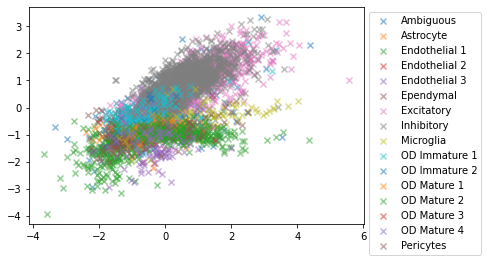

In [12]:
batch=merfish_test.get(0).to('cuda')
model=model.to('cuda')
reps,recon=model(batch)
reps=reps.detach().cpu().numpy()
types=batch.y.detach().cpu().numpy()[:,1]
for i,nm in enumerate(merfish_test.cell_types):
    good=types==i
    plt.scatter(reps[good,0],reps[good,1],alpha=.5,marker='x',label=nm)
plt.legend(bbox_to_anchor=[1,1])